# TERILS MOSDAC RADAR
- @author: Hamid Ali Syed (syed44@purdue.edu)
- @date: Nov 1, 2022
---

### Note
The issue with the data is that it doesn't have sweep start ray index and sweep end ray index. We will try to add these things manually. Also it has issues with timestamp as well. We will try to take care of that as well. Remember to make a backup of the original data, as I will try to rewrite it.

In [29]:
import xarray as xr
import datetime as dt
import pyart
import numpy as np
import wradlib as wrl
import pyscancf as pcf
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter, FuncFormatter
import pandas as pd
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import glob

In [60]:
from matplotlib import axes
from matplotlib.ticker import NullFormatter
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt

In [31]:
files = sorted(glob.glob("RCT*.nc"))
len(files)

2

In [32]:
for file in files:
#     print(file.split("_")[1:3])
    time_str = pd.to_datetime(file.split("_")[1:3][0]+" "+file.split("_")[1:3][1])
#     print(time_str)
    radar = pyart.io.read(file)
    radar.time['units'] = "seconds since "+time_str.to_datetime64().astype(str)[:-7]
    radar.sweep_start_ray_index['data'] = np.arange(0,
                                                radar.azimuth['data'].size,
                                                radar.azimuth['data'].size//radar.sweep_number['data'].size)

    radar.sweep_end_ray_index['data'] = np.arange(radar.azimuth['data'].size//radar.sweep_number['data'].size-1,
              radar.azimuth['data'].size,
              radar.azimuth['data'].size//radar.sweep_number['data'].size)
    pyart.io.write_cfradial(file, radar)

### Watch carefully:
We have rewrote the data with the timestamps and ray indices, now we can normally use these files in any package e.g., wradlib, pyart etc.

In [33]:
radar = pyart.io.read("RCTLS_12OCT2022_103335_L2B_STD.nc")

In [34]:
display = pyart.graph.RadarDisplay(radar)

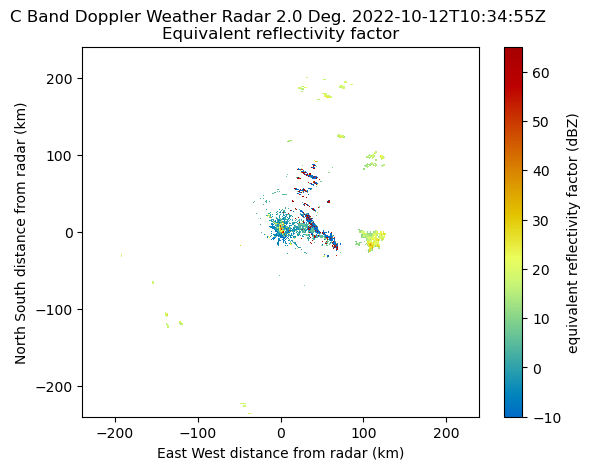

In [35]:
display.plot("DBZ", 2)

In [36]:
import pyscancf as pcf
grid = pcf.get_grid(radar, grid_shape=(200, 500, 500), height=15, length=200)

In [37]:
xgrid = grid.to_xarray()

In [38]:
grid.fields['REF'] = grid.fields['DBZ']

Generating Figures of Max-CAPPI, please be patient!
Figures saved


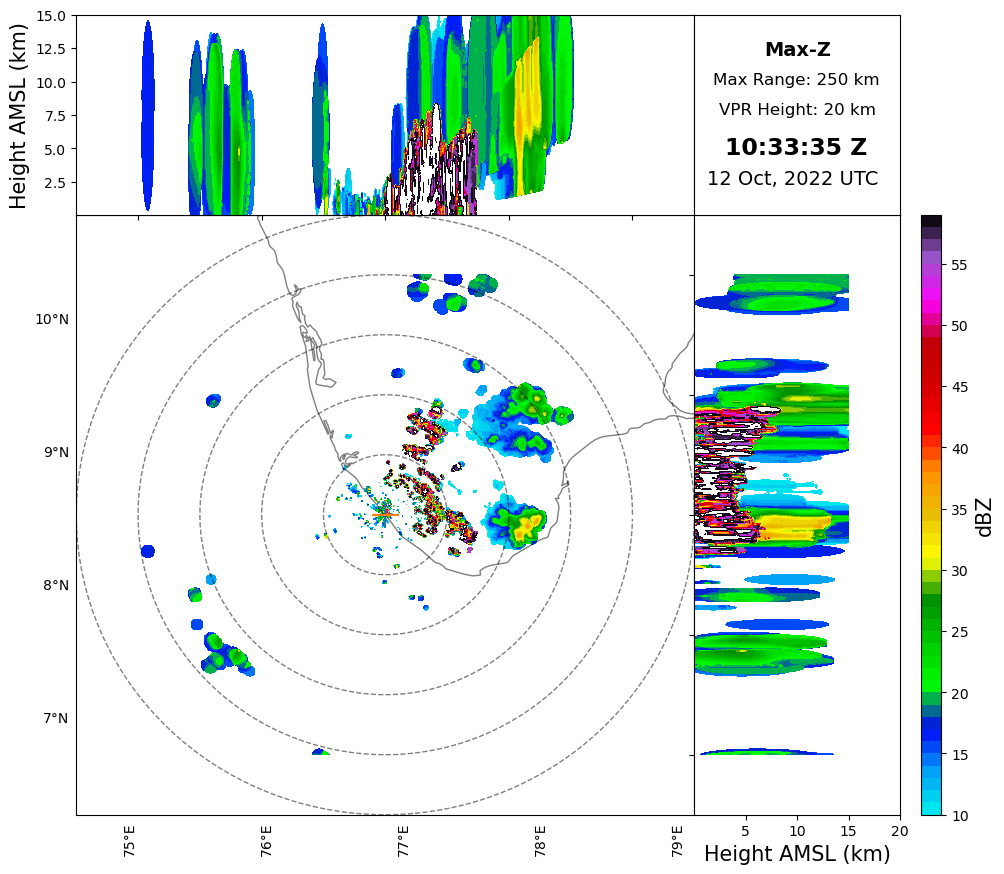

In [39]:
pcf.plot_cappi(grid, "REF")

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

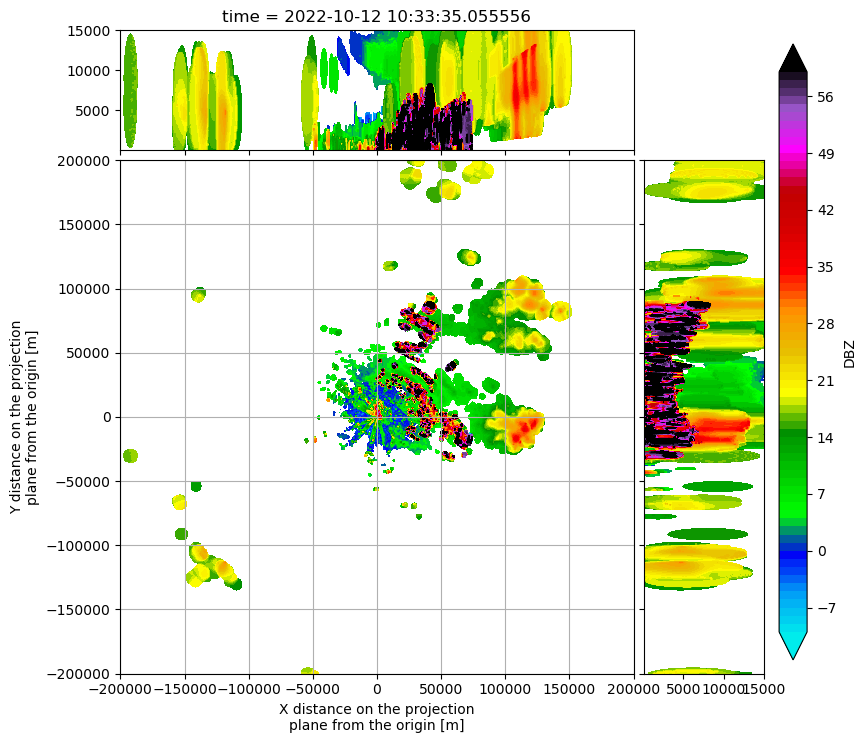

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1.)
xgrid['DBZ'][0].max(axis=0).plot.contourf(cmap='pyart_NWSRef',
                                          levels=range(-10,60),
                                          cbar_kwargs={'pad':0.02,
                                                       'shrink':0.8},
                                          ax=ax)
ax.grid()
ax.set_title(None)
# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_x = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)
xgrid['DBZ'][0].max(axis=1).plot.contourf(cmap='pyart_NWSRef',levels=range(-10,60),add_colorbar=False,ax=ax_x)
xgrid['DBZ'][0].max(axis=2).T.plot.contourf(cmap='pyart_NWSRef',levels=range(-10,60),
                                         add_colorbar=False,add_title=None,ax=ax_y,)
ax_y.set_title(None)
ax_y.set_xlabel(None);ax_y.set_ylabel(None);ax_x.set_xlabel(None);ax_x.set_ylabel(None)
plt.show()

or you can plot at any height (CAPPI)

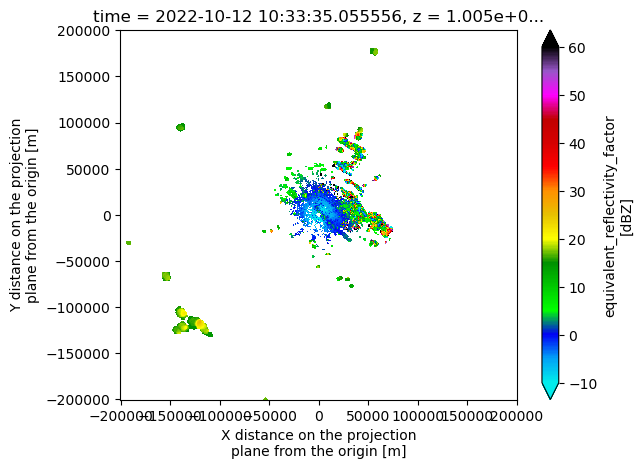

In [42]:
xgrid.DBZ[0].sel(z = 1000, method = "nearest").plot(vmin=-10, vmax = 60, cmap = "pyart_NWSRef") # 1000 is 1km there

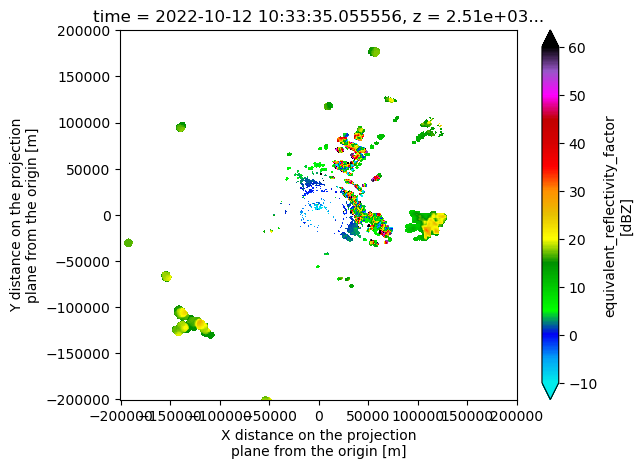

In [43]:
xgrid.DBZ[0].sel(z = 2500, method = "nearest").plot(vmin=-10, vmax = 60, cmap = "pyart_NWSRef") # 1000 is 1km there

In [44]:
import wradlib as wrl

In [45]:
vol = wrl.io.open_cfradial1_dataset("RCTLS_12OCT2022_103335_L2B_STD.nc")
swp_list = []
for v in vol:
     # georeference and stack dimensions
    swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
    swp_list.append(swp)
# concat sweeps to volume
vol0 = xr.concat(swp_list, dim="points")
# Create XYZ Coordinate DataArray
xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()
# Create Target 3D Grid
trgx = np.linspace(xyz[:, 0].min(),xyz[:, 0].max(), 500)
trgy = np.linspace(xyz[:, 1].min(),xyz[:, 1].max(), 500)
trgz = np.linspace(0, 20000, 100)
yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T
# Create Gridder/Interpolator
trgshape=xx.shape
gridder = wrl.vpr.CAPPI(polcoords=xyz,
                     gridcoords=trgxyz,
                     gridshape=trgshape,
                     maxrange=200000,
                     minelev=0,
                     maxelev=21,
                     ipclass=wrl.ipol.Nearest)
# Interpolate Data into 3D Grid
crtd_ref = vol0.DBZ#.where(((vol0.RHOHV < 1.0) & (vol0.ZDR>-4) & ((vol0.PHIDP > 150) | (vol0.PHIDP < -150))))
vol_zh = np.ma.masked_invalid(gridder(crtd_ref.values).reshape(trgshape))
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]

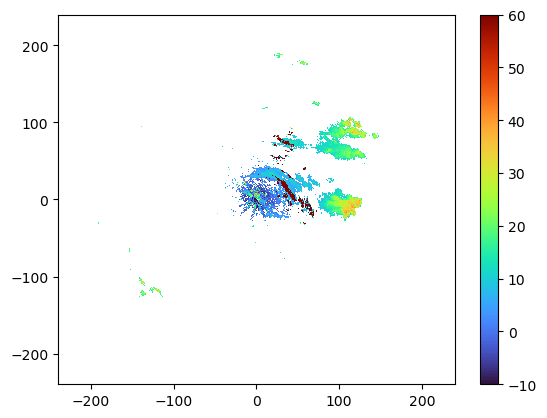

In [46]:
plt.pcolormesh(trgx/1e3, trgy/1e3, vol_zh.max(axis=0), vmin = -10, vmax = 60, cmap="turbo")
plt.colorbar()

In [48]:
import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.Stamen('terrain-background')

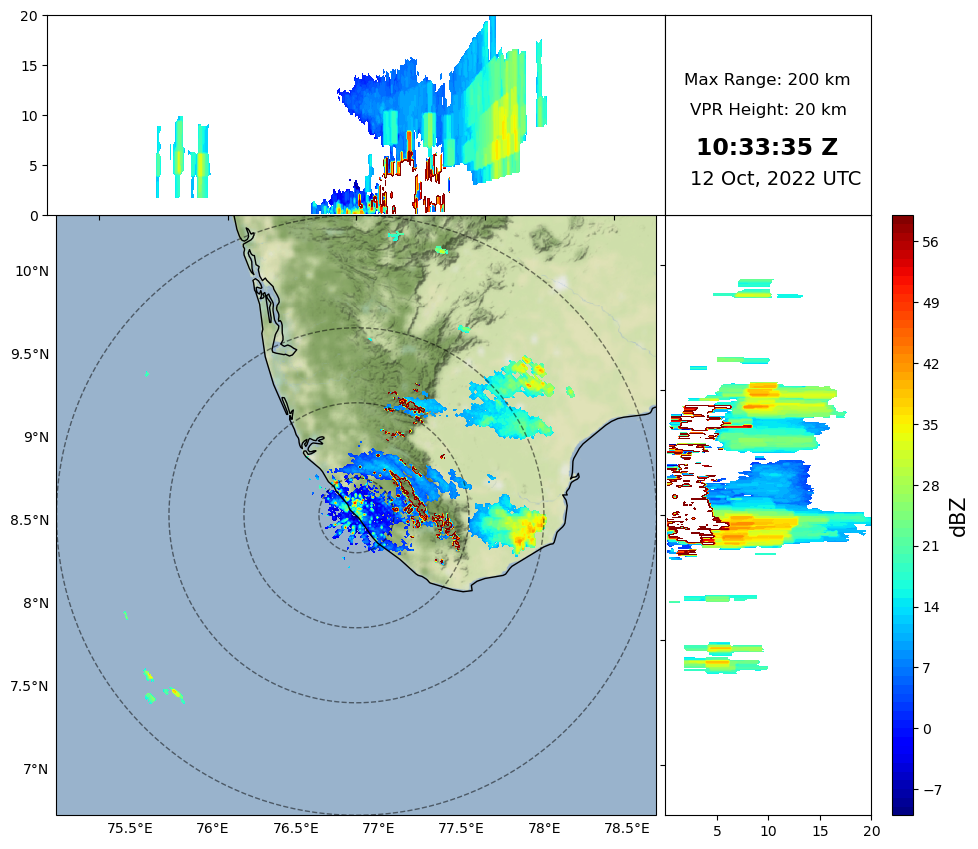

In [63]:
fig = plt.figure(figsize=(10.3,10))
# define axes
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
ax_xy = plt.axes((left, bottom, width, width),projection=ccrs.LambertAzimuthalEqualArea(v.longitude.values,
                                                                                   v.latitude.values))
ax_x = plt.axes((left, bottom + width, width, height))
ax_y = plt.axes((left + width, bottom, height, width))
ax_cnr = plt.axes((left+width, bottom + width, left+left,height))
ax_cb = plt.axes((left + width + height + 0.02, bottom, 0.02, width))

# set axis label formatters
ax_x.xaxis.set_major_formatter(NullFormatter())
ax_y.yaxis.set_major_formatter(NullFormatter())
ax_cnr.yaxis.set_major_formatter(NullFormatter())
ax_cnr.xaxis.set_major_formatter(NullFormatter())

# # label axes
# ax_xy.set_xlabel("Longitude [°E]",fontsize=15)
# ax_xy.set_ylabel("Latitude [°N]",fontsize=15)
# ax_x.set_xlabel("")
# ax_x.set_ylabel("Height AMSL (km)",fontsize=15)
# ax_y.set_ylabel("")
# ax_y.set_xlabel("Height AMSL (km)",fontsize=15)

# draw CAPPI
plt.sca(ax_xy)
xy = ax_xy.contourf(trgx,trgy,vol_zh.max(axis=0),cmap='jet',levels=range(-10,60))
gl = ax_xy.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, 
                     linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'weight': 'bold'}
# gl.ylabel_style = {'weight': 'bold'}

[ax_xy.plot(r * np.cos(np.arange(0,360) * np.pi / 180), 
         r * np.sin(np.arange(0,360) * np.pi / 180), 'k--', linewidth=1, alpha=0.5) for r in [25000,75000,125000,
                                                                                              200000]]
ax_xy.set_xlim(-200000,200000)
ax_xy.set_ylim(-200000,200000)
# ax_xy.plot([0,0],[-10000,10000],'-')
# ax_xy.plot([-10000,10000],[0,0],'-')
# ax_xy.scatter(0,0, marke)

## plot terrain
ax_xy.add_image(stamen_terrain, 8)
ax_xy.coastlines()
ax_xy.add_feature(feat.OCEAN, alpha = 0.5)

# draw colorbar
cb = plt.colorbar(xy, cax=ax_cb)
cb.set_label('dBZ',fontsize=15)

plt.sca(ax_x)
plt.contourf(trgx/1e3,trgz/1e3,vol_zh.max(axis=1),cmap='jet',levels=range(-10,70))
# plt.ylim(0,20)
# plt.yticks([0,5,10,15,20])
# plt.grid(axis='y')

plt.sca(ax_y)
plt.contourf(trgz/1e3,trgy/1e3,vol_zh.max(axis=2).T,cmap='jet',levels=range(-10,60))
# plt.xlim(0,20)
ax_y.set_xticks([5,10,15,20])
# plt.grid(axis='x')

plt.sca(ax_cnr)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
# labels along the bottom edge are off
plt.text(0.09,0.65,'Max Range: 200 km',fontsize=12)
plt.text(0.12,0.5,'VPR Height: 20 km',fontsize=12)
plt.text(0.15,0.3,pd.to_datetime(vol[0].time.values).strftime('%H:%M:%S Z'),weight='bold',fontsize=17)
plt.text(0.12,0.15,pd.to_datetime(vol[0].time.values).strftime('%d %b, %Y UTC'),fontsize=14)
ax_xy.set_aspect('auto')
# plt.savefig('plots/'+'Shp_Max-Z_'+str(filename[-29:82])+'.jpg',dpi=200,bbox_inches='tight')

---
### Based on Mr Kai's Solution posted at https://openradar.discourse.group/
---

In [9]:
# Just open as simple xarray.Dataset, not decoding times
vol = xr.open_dataset("RCTLS_12OCT2022_104600_L2B_STD.nc", decode_times=False)

# 1./2.  fix time unit and time_coverage_start
start_time = "".join(vol.time_coverage_start.astype(str).values)
start_time = dt.datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ")
vol["time_coverage_start"] = start_time
# time-units is wrong: "seconds since yyyy-mm-ddThh:mm:ssZ"
vol["time"].attrs["units"] = f"seconds since {start_time}"
# new correct value: "seconds since 2017-11-30 00:09:57"
# now we can decode time (!)
vol = xr.decode_cf(vol)

# 4. fix ray_index
# we have wrong values here, so that we cannot extract the individual sweeps
# sweep_start_ray_index: array([0, 0, 0], dtype=int32)
# sweep_end_ray_index: array([0, 0, 0], dtype=int32)

# to resolve this we identify these indices with the help of elevation
# get unique elevations (removing "0" in this case, as it is not an elevation)
ele = sorted(list(set(vol.elevation.values) ^ {0}))
vele = vol.elevation
sweep_start_ray_index = [vele.where(vele==el).argmin("time").values.item() for el in ele]
sweep_end_ray_index = [vol.dims["time"] - vele.where(vele==el)[::-1].argmin("time").values.item() for el in ele]
vol["sweep_start_ray_index"].values = sweep_start_ray_index
vol["sweep_end_ray_index"].values = sweep_end_ray_index

# assign data to wradlib RadarVolume()
# now we have everything in place and can extract individual sweeps
# this is done via private functions of wradlib, so take with care
sweeps = [wrl.io.xarray._assign_data_radial(vol, sweep=f"sweep_{i+1}")[0] for i in range(vol.dims["sweep"])]
new_vol = wrl.io.RadarVolume(engine="cfradial1")
new_vol.extend(sweeps)
new_vol.sort(key=lambda x: x.time.min().values)

# write to CfRadial2-like file (which can be read by new package https://github.com/openradar/xradar)
new_vol.to_cfradial2("test_cfradial2.nc")

After that you can interpolate your data into a 3D-grid and plot MAX CAPPI like:

In [23]:
# Iterate over sweeps and process
swp_list = []
for v in new_vol:
    # georeference and stack dimensions
    swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
    swp_list.append(swp)

# concat sweeps to volume
vol0 = xr.concat(swp_list, dim="points")

# Create XYZ Coordinate DataArray
xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()

# Create Target 3D Grid, choose your wanted resolution
xcnt = 500
ycnt = 500
zcnt = 300
trgx = np.linspace(xyz[:, 0].min(),xyz[:, 0].max(), xcnt)
trgy = np.linspace(xyz[:, 1].min(),xyz[:, 1].max(), ycnt)
trgz = np.linspace(0, 15000, zcnt)
yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T
trgshape=xx.shape
# Create Gridder/Interpolator
gridder = wrl.vpr.CAPPI(polcoords=xyz,
                     gridcoords=trgxyz,
                     gridshape=trgshape,
                     maxrange=200000,
                     minelev=0,
                     maxelev=21,
                     ipclass=wrl.ipol.Nearest)
# Interpolate Data into 3D Grid
crtd_ref = vol0.DBZ#.where(((vol0.RHOHV < 1.0) & (vol0.ZDR>-4) & ((vol0.PHIDP > 150) | (vol0.PHIDP < -150))))
vol_zh = np.ma.masked_invalid(gridder(crtd_ref.values).reshape(trgshape))
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]

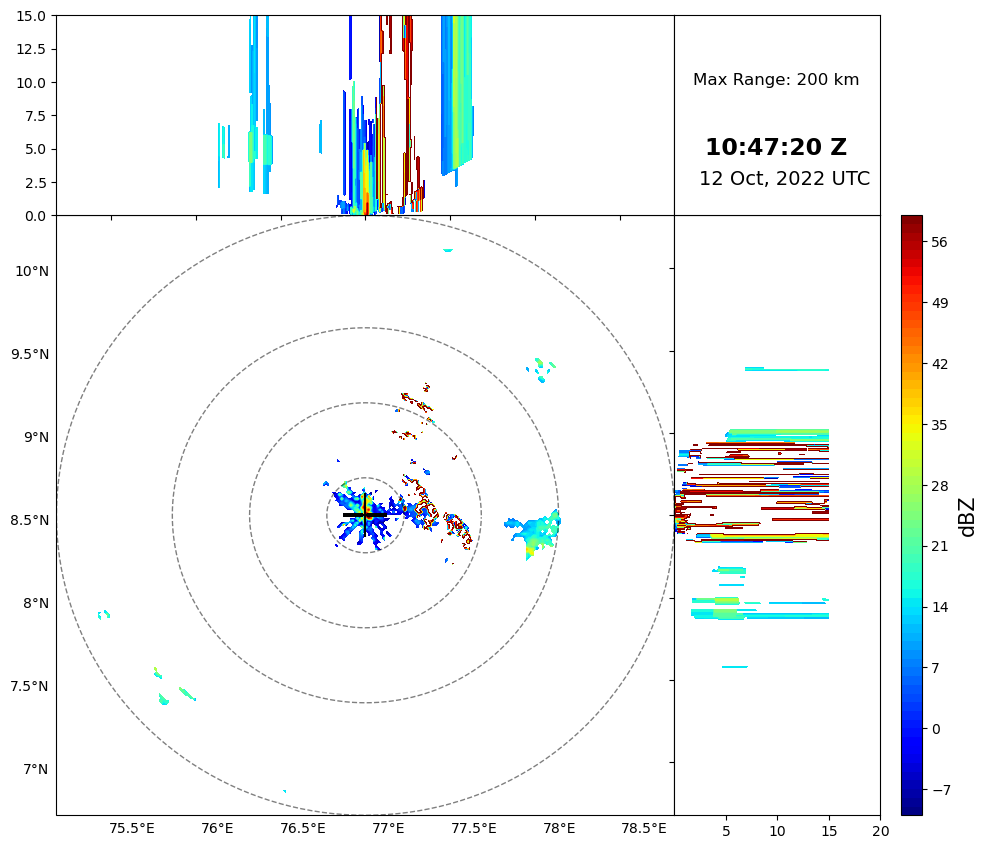

In [28]:
fig = plt.figure(figsize=(10.3,10))
# define axes
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
ax_xy = plt.axes((left, bottom, width, width),projection=ccrs.LambertAzimuthalEqualArea(v.longitude.values,
                                                                                   v.latitude.values))
ax_x = plt.axes((left, bottom + width, width, height))
ax_y = plt.axes((left + width, bottom, height, width))
ax_cnr = plt.axes((left+width, bottom + width, left+left,height))
ax_cb = plt.axes((left + width + height + 0.02, bottom, 0.02, width))

# set axis label formatters
ax_x.xaxis.set_major_formatter(NullFormatter())
ax_y.yaxis.set_major_formatter(NullFormatter())
ax_cnr.yaxis.set_major_formatter(NullFormatter())
ax_cnr.xaxis.set_major_formatter(NullFormatter())

# # label axes
# ax_xy.set_xlabel("Longitude [°E]",fontsize=15)
# ax_xy.set_ylabel("Latitude [°N]",fontsize=15)
# ax_x.set_xlabel("")
# ax_x.set_ylabel("Height AMSL (km)",fontsize=15)
# ax_y.set_ylabel("")
# ax_y.set_xlabel("Height AMSL (km)",fontsize=15)

# draw CAPPI
plt.sca(ax_xy)
xy = ax_xy.contourf(trgx,trgy,vol_zh.max(axis=0),cmap='jet',levels=range(-10,60))
gl = ax_xy.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, 
                     linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'weight': 'bold'}
# gl.ylabel_style = {'weight': 'bold'}

[ax_xy.plot(r * np.cos(np.arange(0,360) * np.pi / 180), 
         r * np.sin(np.arange(0,360) * np.pi / 180), 'k--', linewidth=1, alpha=0.5) for r in [25000,75000,125000,
                                                                                              200000]]
ax_xy.set_xlim(-200000,200000)
ax_xy.set_ylim(-200000,200000)
# ax_xy.plot([0,0],[-10000,10000],'-')
# ax_xy.plot([-10000,10000],[0,0],'-')
ax_xy.scatter(0,0, marker="+", s=1000, c="k")

# draw colorbar
cb = plt.colorbar(xy, cax=ax_cb)
cb.set_label('dBZ',fontsize=15)

plt.sca(ax_x)
plt.contourf(trgx/1e3,trgz/1e3,vol_zh.max(axis=1),cmap='jet',levels=range(-10,70))
# plt.ylim(0,20)
# plt.yticks([0,5,10,15,20])
# plt.grid(axis='y')

plt.sca(ax_y)
plt.contourf(trgz/1e3,trgy/1e3,vol_zh.max(axis=2).T,cmap='jet',levels=range(-10,60))
# plt.xlim(0,20)
ax_y.set_xticks([5,10,15,20])
# plt.grid(axis='x')

plt.sca(ax_cnr)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
# labels along the bottom edge are off
plt.text(0.09,0.65,'Max Range: 200 km',fontsize=12)
# plt.text(0.12,0.5,'VPR Height: 20 km',fontsize=12)
plt.text(0.15,0.3,pd.to_datetime(swp.time.values).strftime('%H:%M:%S Z'),weight='bold',fontsize=17)
plt.text(0.12,0.15,pd.to_datetime(swp.time.values).strftime('%d %b, %Y UTC'),fontsize=14)
ax_xy.set_aspect('auto')
# plt.savefig('plots/'+'Shp_Max-Z_'+str(filename[-29:82])+'.jpg',dpi=200,bbox_inches='tight')